In [2]:
library(zoo)
library(forecast)


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 



In [1]:
preprocessing <- function(ts_csv, total_csv){
    
    # removes rows with low observations and locfs them
    # returns time series and total time series, as a list
    
    ts = read.csv(ts_csv)
    total <- read.csv(total_csv)
    df = data.frame(ts)
    df_total = data.frame(total)
    
    missing = df_total[,'total']<5000
    print(which(missing))
    df_total[missing, 'total'] <- NA
    df[missing,] <-NA
    ts_total = ts(na.locf(df_total[,'total']))
    ts_filled = ts(na.locf(df[, ncol(df)]))
    return(list(series=ts_filled, total=ts_total))
}

Clean up data and fill in NaNs, and unify the length of the time series to 28 days. We look at September 2-29 and June 3-30. The June data doesn't have any missing data in the time span we are looking at.

In [93]:
sept_cas = ts(preprocessing('E:/summary/sept_casual.csv', 'E:/summary/sept_total.csv')$series[25:696], frequency=24)
sept_tot = ts(preprocessing('E:/summary/sept_casual.csv', 'E:/summary/sept_total.csv')$total[25:696], frequency=24)

 [1] 408 409 470 476 477 712 713 714 715 716
 [1] 408 409 470 476 477 712 713 714 715 716


In [92]:
june_cas = ts(preprocessing('E:/summary/june_casual.csv', 'E:/summary/june_total.csv')$series[49:720], frequency=24)
june_tot = ts(preprocessing('E:/summary/june_casual.csv', 'E:/summary/june_total.csv')$total[49:720], frequency=24)

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723


In [143]:
july_cas = ts(preprocessing('E:/summary/july/july_casual.csv', 'E:/summary/july/july_total.csv')$series[49:720], frequency=24)
july_tot = ts(preprocessing('E:/summary/july/july_casual.csv', 'E:/summary/july/july_total.csv')$total[49:720], frequency=24)

[1] 206 207
[1] 206 207


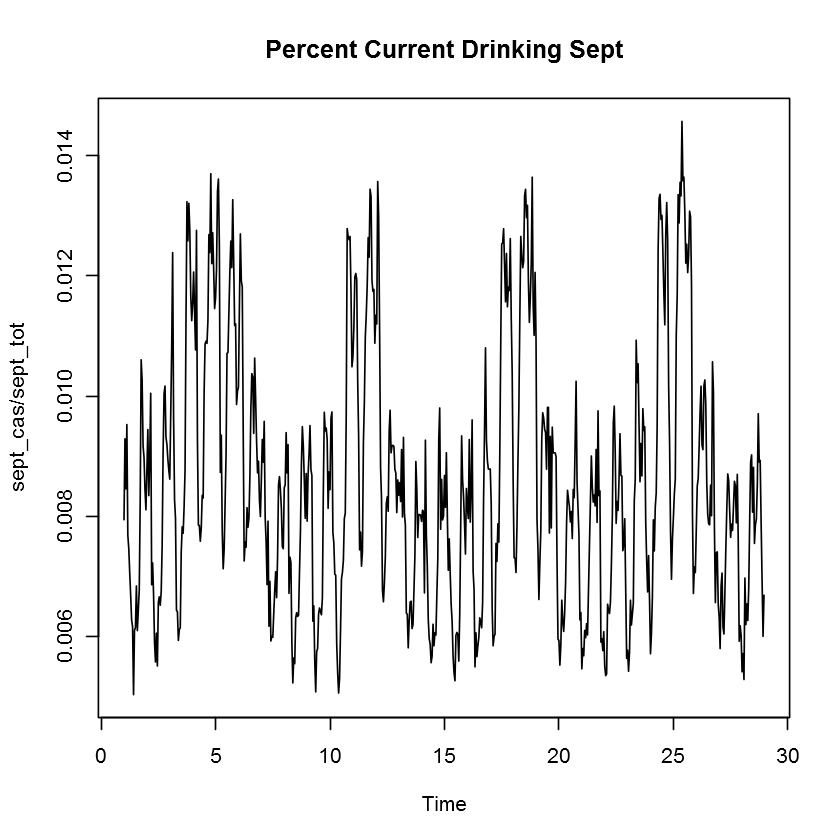

In [139]:
plot(sept_cas/sept_tot, main='Percent Current Drinking Sept')

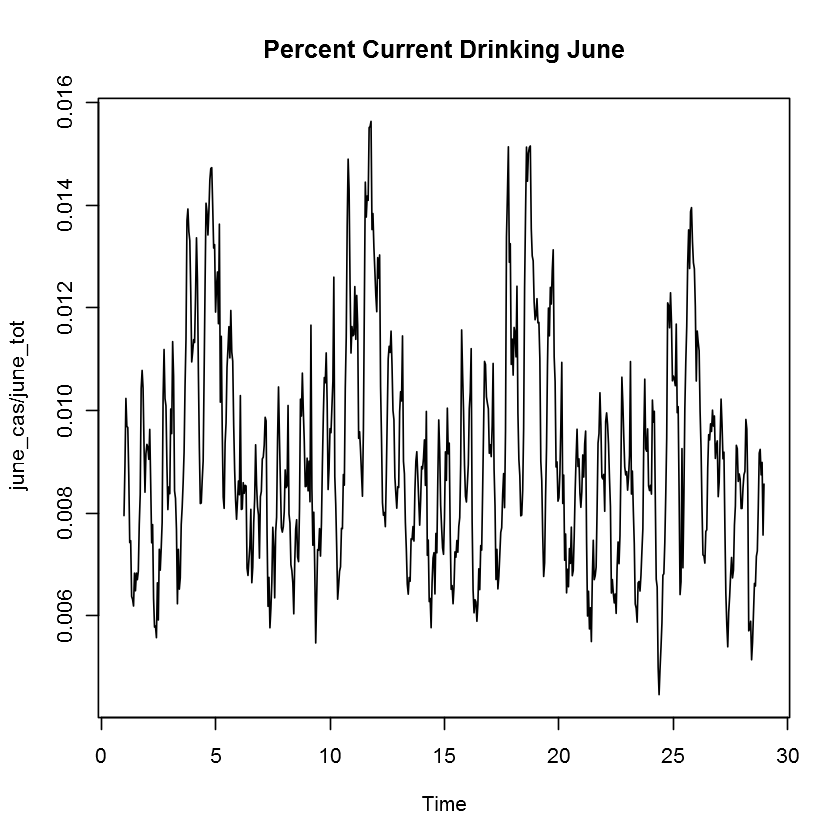

In [140]:
plot(june_cas/june_tot, main='Percent Current Drinking June')

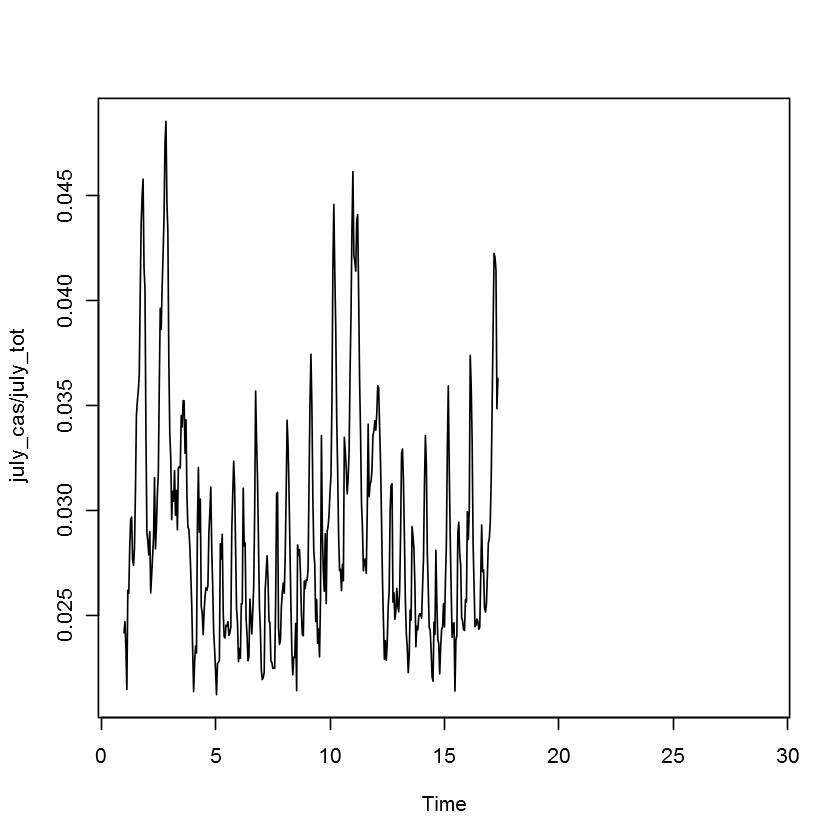

In [145]:
plot(july_cas/july_tot)

# ARIMA

Difference by week/day, the fit ARIMA(2,0,2)x(2,0,2)

In [153]:
sept_perc = diff(diff(log(sept_cas/sept_tot), 168), 24)
june_perc = diff(diff(log(june_cas/june_tot), 168), 24)

Plot the differenced data. There are still visible cycles which indicate that there are significant differences between the weeks, especially in September. This might suggest that ARIMA won't fit perfectly.

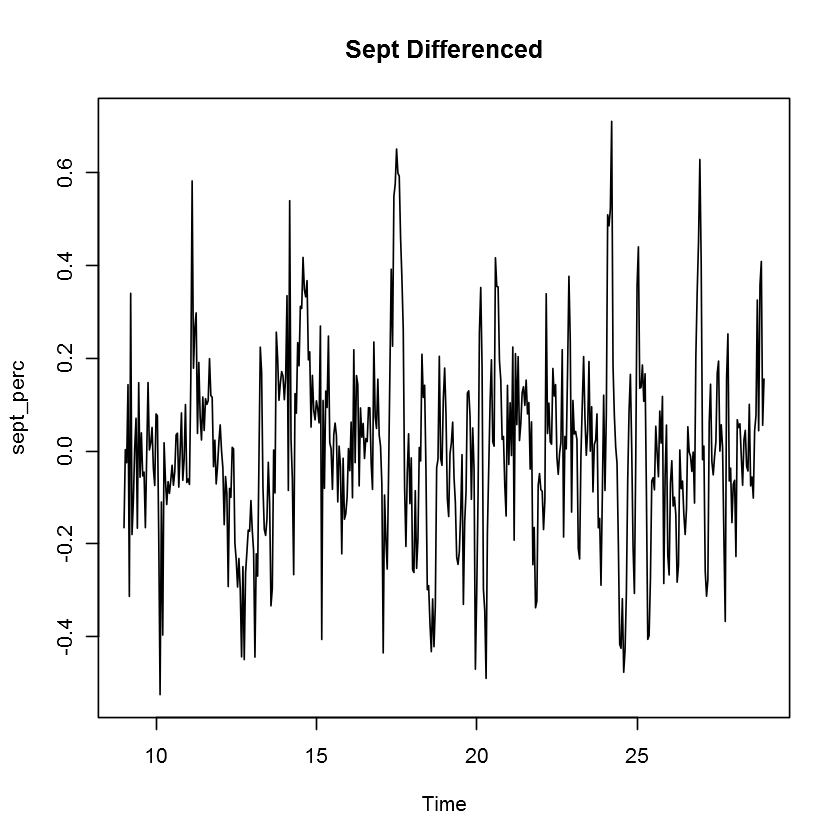

In [135]:
plot(sept_perc, type='l', main='Sept Differenced')

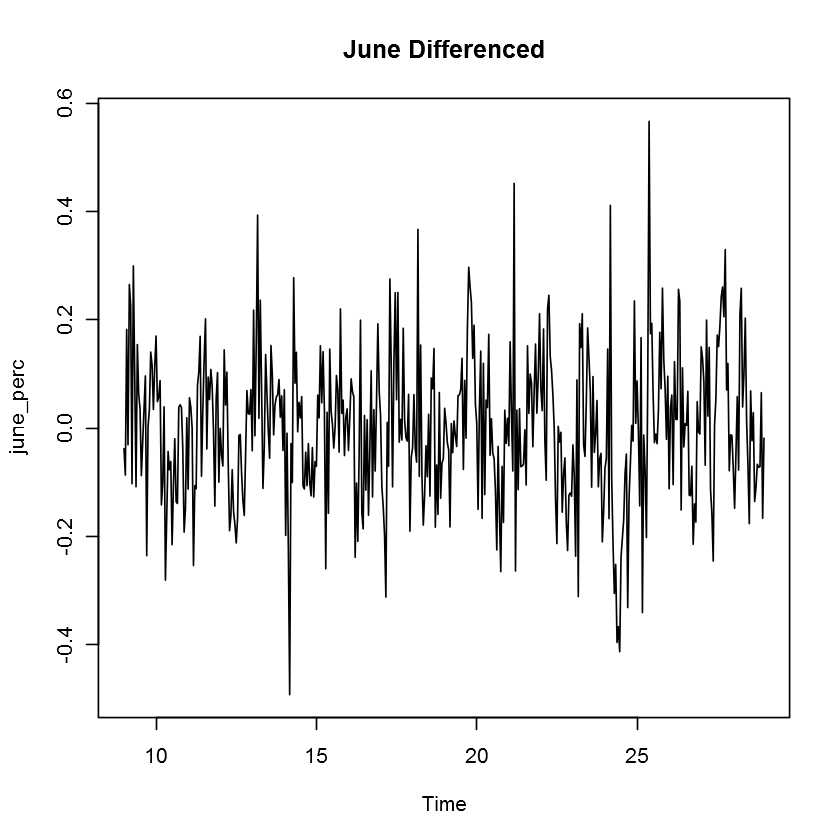

In [136]:
plot(june_perc, type='l', main='June Differenced')

In [23]:
library(astsa)


Attaching package: 'astsa'

The following object is masked from 'package:forecast':

    gas



In [133]:
sept_arima = arima(sept_perc, order=c(2, 0, 2), seasonal=list(order=c(2, 0, 2), period=24))

In [138]:
june_arima = arima(june_perc, order=c(2, 0, 2), seasonal=list(order=c(2, 0, 2), period=24))

When comparing the arima coefficients, the seasonal (daily) are similar but the hourly are not.

In [137]:
sept_arima

Warning message:
In sqrt(diag(x$var.coef)): NaNs producedWarning message:
In sqrt(diag(x$var.coef)): NaNs produced


Call:
arima(x = sept_perc, order = c(2, 0, 2), seasonal = list(order = c(2, 0, 2), 
    period = 24))

Coefficients:
         ar1      ar2      ma1     ma2    sar1    sar2     sma1     sma2
      0.8909  -0.1971  -0.2015  0.2242  -0.603  0.2851  -0.0923  -0.7831
s.e.     NaN   0.0260   0.0443  0.0595   0.046  0.0400   0.0644   0.0669
      intercept
         0.0047
s.e.     0.0044

sigma^2 estimated as 0.01634:  log likelihood = 287.31,  aic = -554.62

In [141]:
june_arima


Call:
arima(x = june_perc, order = c(2, 0, 2), seasonal = list(order = c(2, 0, 2), 
    period = 24))

Coefficients:
          ar1     ar2     ma1      ma2     sar1     sar2     sma1     sma2
      -0.0908  0.6568  0.3854  -0.3517  -0.5364  -0.1819  -0.2427  -0.3740
s.e.   0.2780  0.2380  0.2959   0.1915   0.1324   0.0758   0.1325   0.1245
      intercept
        -0.0047
s.e.     0.0029

sigma^2 estimated as 0.009722:  log likelihood = 417.97,  aic = -815.94

In [148]:
residual_analysis <- function(res){
    tsdisplay(res, lag.max=200)
    qqnorm(res)
    plot(density(res))
    
}

Residual analysis: September residuals are more normal but fail the Ljung-box test up to lag 48 (2x length of the season component is considered a good rule of thumb from what I've seen), which basically tests the significance of all autocorrelations of the residuals up to lag 48. The June fit passes this test. Residuals from both months still display some negative autocorrelation at 168 hours which indicates that the weekly component is not described well by differencing.

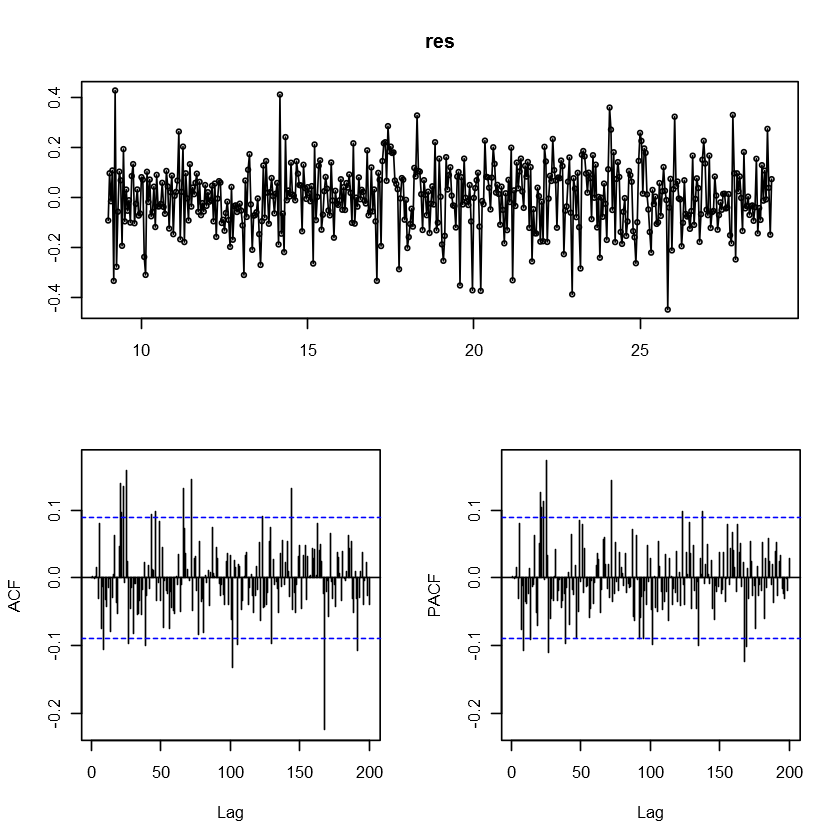

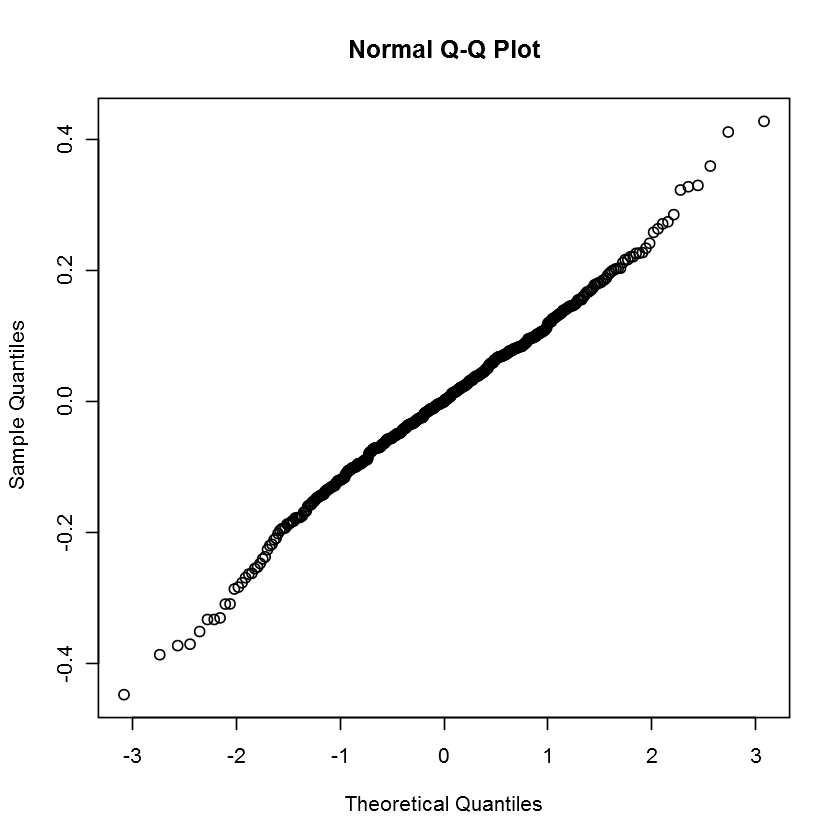

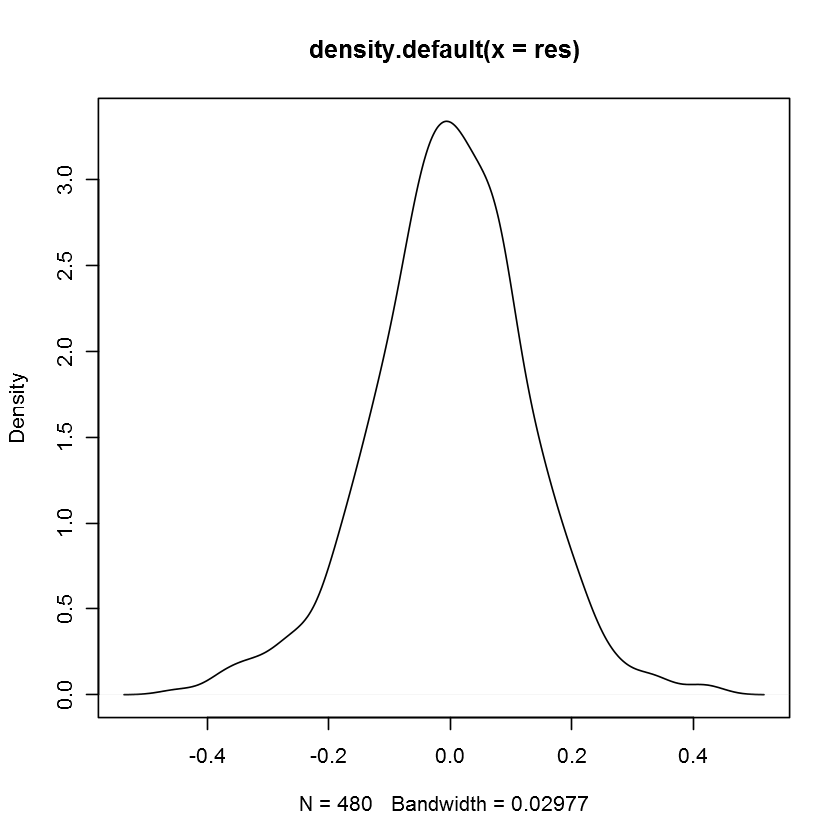

In [149]:
residual_analysis(sept_arima$residuals)

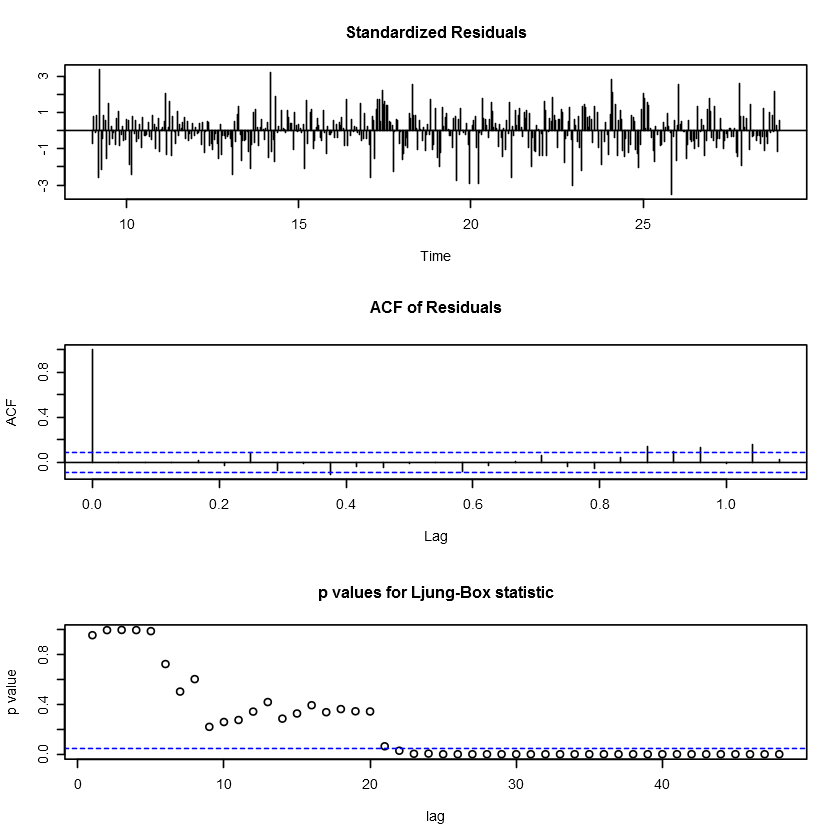

In [151]:
tsdiag(sept_arima, gof.lag=48)

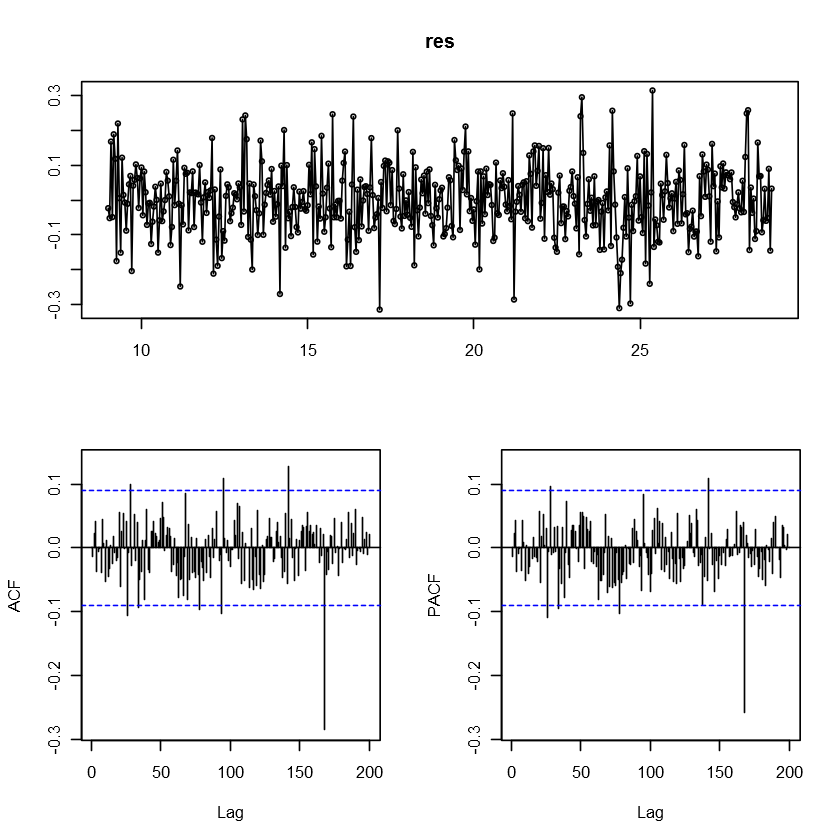

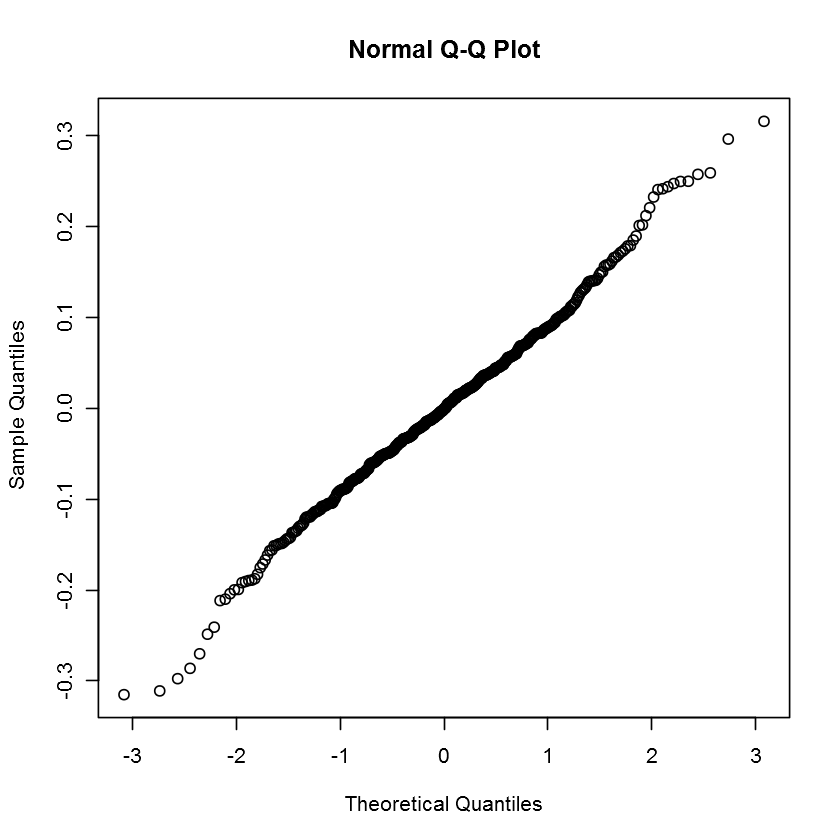

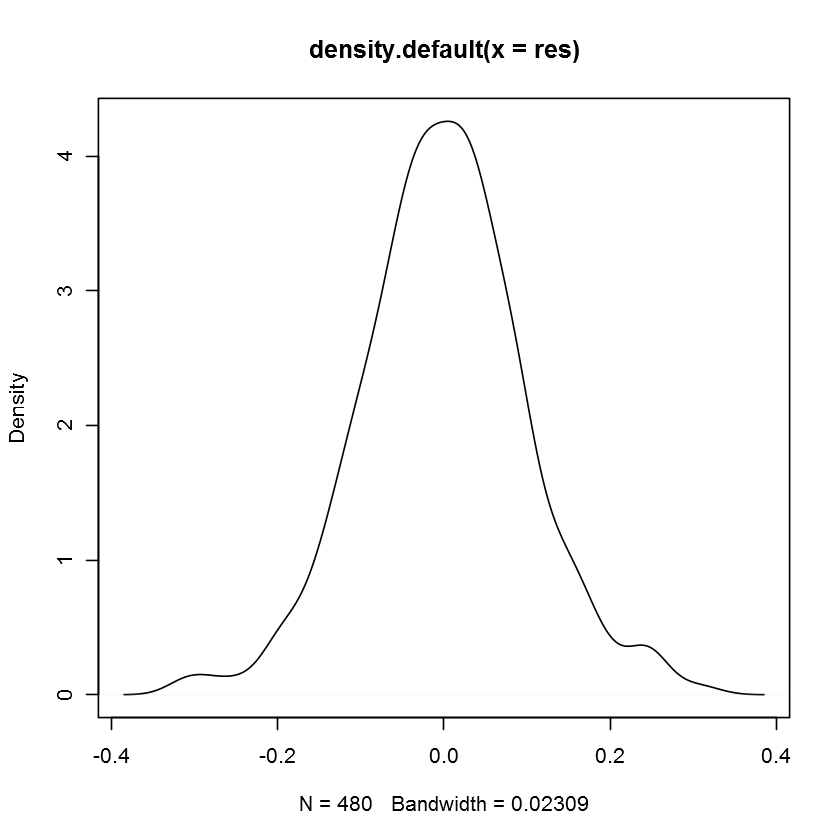

In [152]:
residual_analysis(june_arima$residuals)

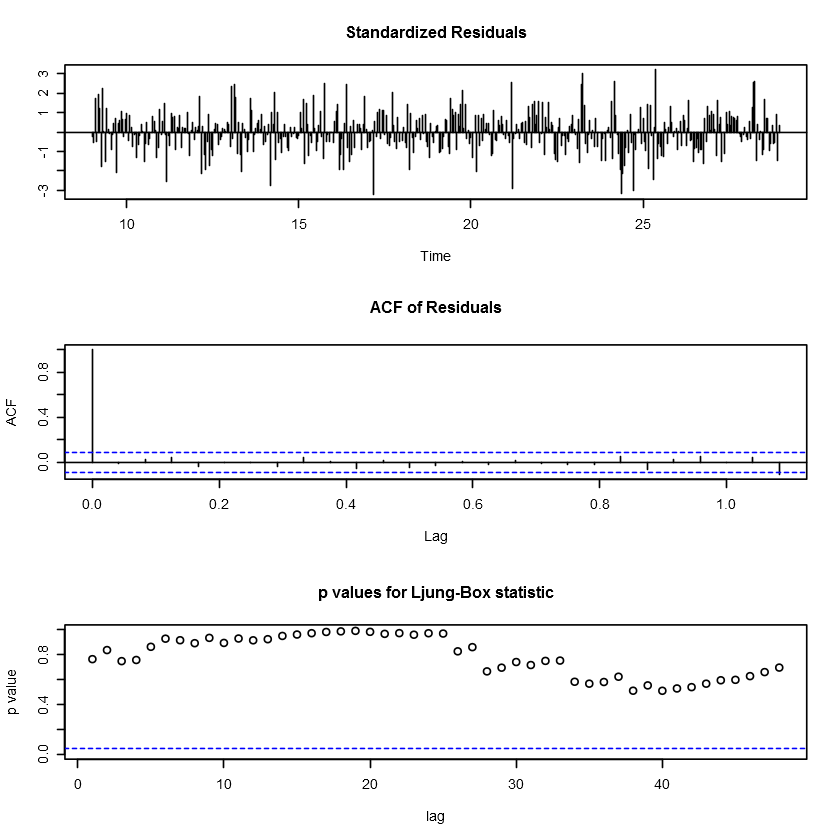

In [156]:
tsdiag(june_arima, gof.lag=48)

# Fourier

DFT of both months. The June DFT is significantly cleaner which is probably due to the the missing datapoints in Sept.

In [98]:
sept_freq = ts(abs(fft(sept_cas/sept_tot)^2)[2:300])

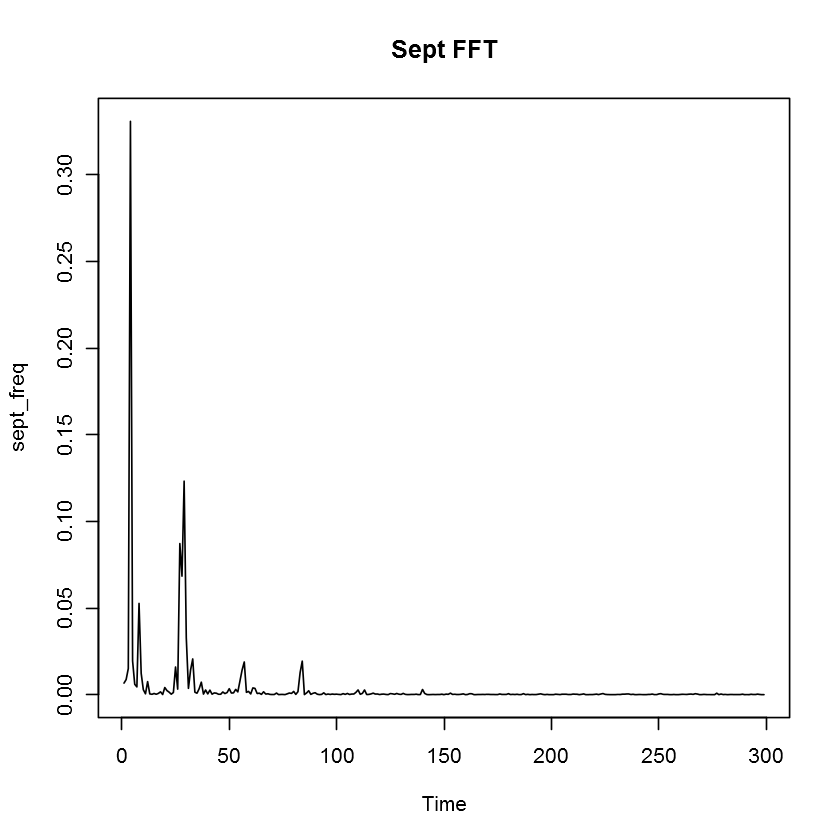

In [127]:
plot(sept_freq, main='Sept DFT')

In [100]:
june_freq = ts(abs(fft(june_cas/june_tot)^2)[2:300])

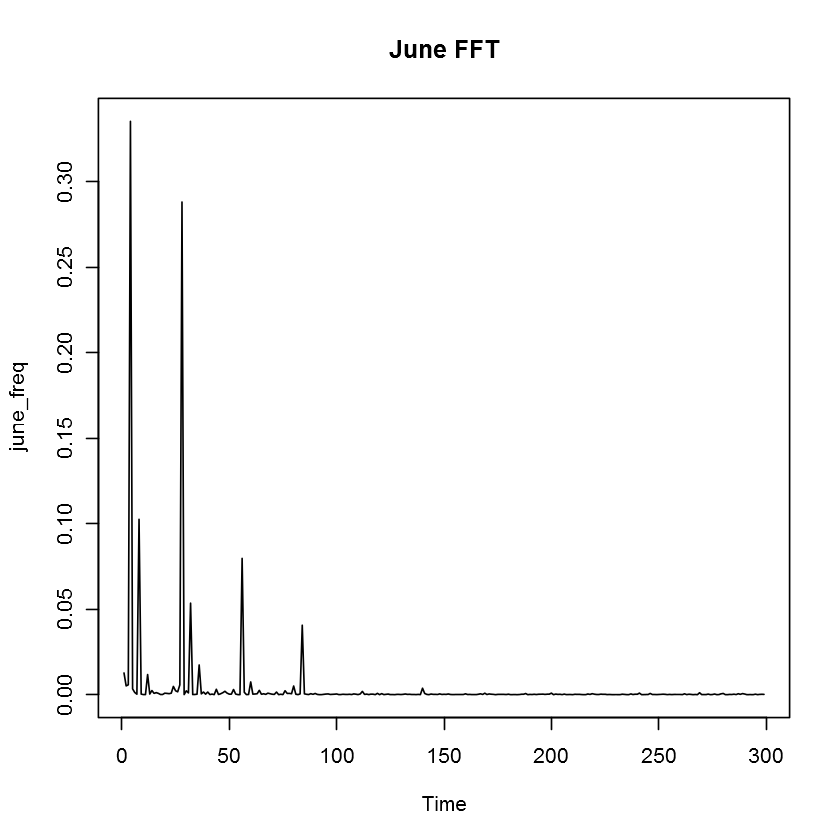

In [128]:
plot(june_freq, main='June DFT')

# DWT

We look at at the levels of DWT that are the most interpretable. Usually it only makes sense to compare the amplitudes between levels within a single wavelet transform which basically indicates how much of the series is explained by each frequency band. However the Sept and June time series had similar enough amplitudes (~0.01 average) so the DWTs were very similar. I decided unified the y-axis between the levels for each month. The x axis is 28*7 hours sampled every 2^(level)

In [54]:
library('wavelets')


Attaching package: 'wavelets'

The following object is masked from 'package:timeDate':

    align



In [102]:
length(sept_cas)

[1] 672

In [103]:
june_dwt = dwt((june_cas/june_tot), filter='d8')

In [104]:
sept_dwt = dwt((sept_cas/sept_tot), filter='d8')

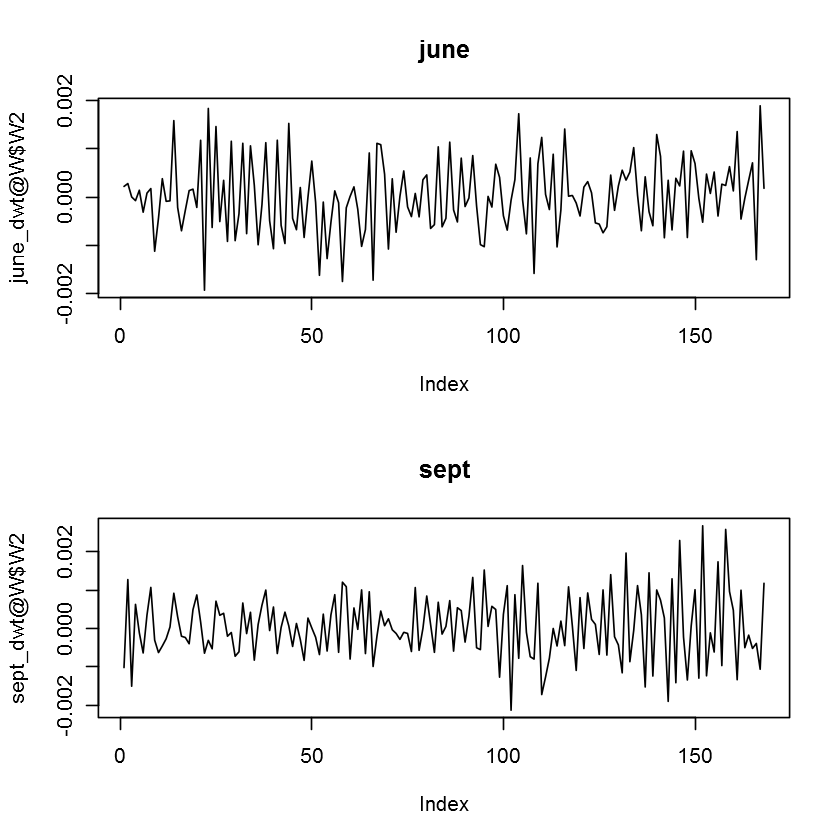

In [114]:
par(mfrow=2:1)
plot(june_dwt@W$W2, type='l', main='june')
plot(sept_dwt@W$W2, type='l', main='sept')

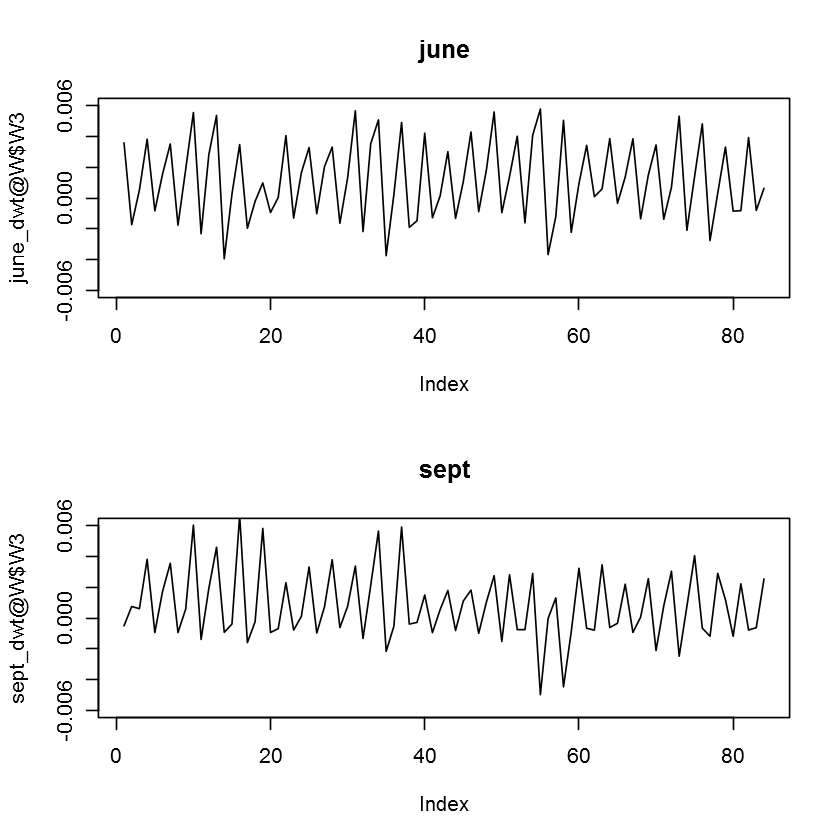

In [118]:
par(mfrow=2:1)
plot(june_dwt@W$W3, type='l', main='june',ylim = c(-0.006, 0.006))
plot(sept_dwt@W$W3, type='l', main='sept',ylim = c(-0.006, 0.006))

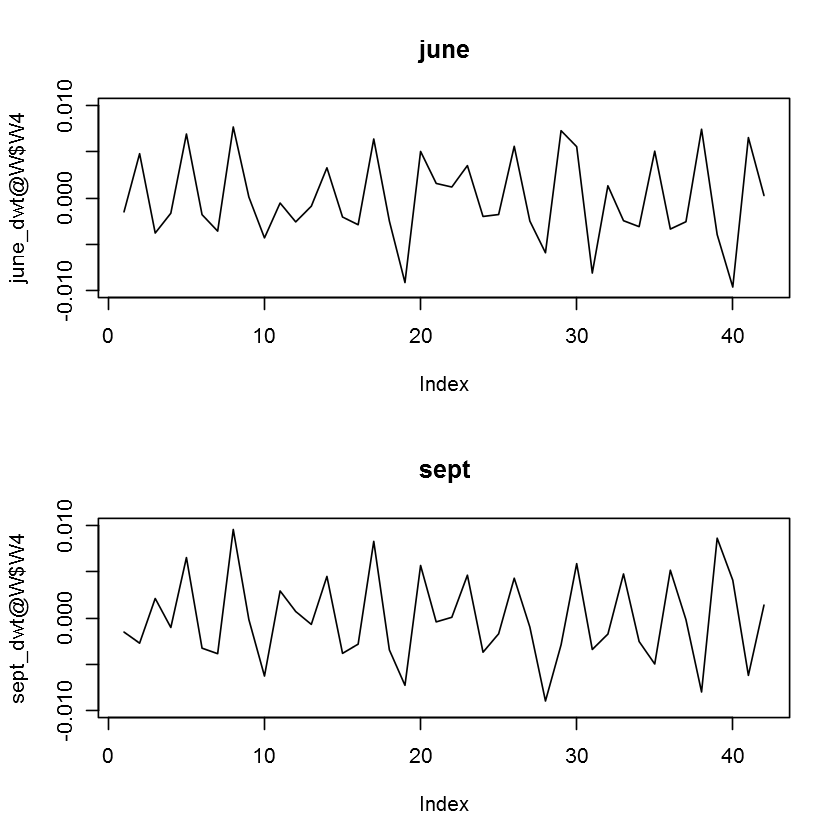

In [126]:
par(mfrow=2:1)
plot(june_dwt@W$W4, type='l', ylim=c(-0.01, 0.01), main='june')
plot(sept_dwt@W$W4, type='l', ylim=c(-0.01, 0.01), main='sept')

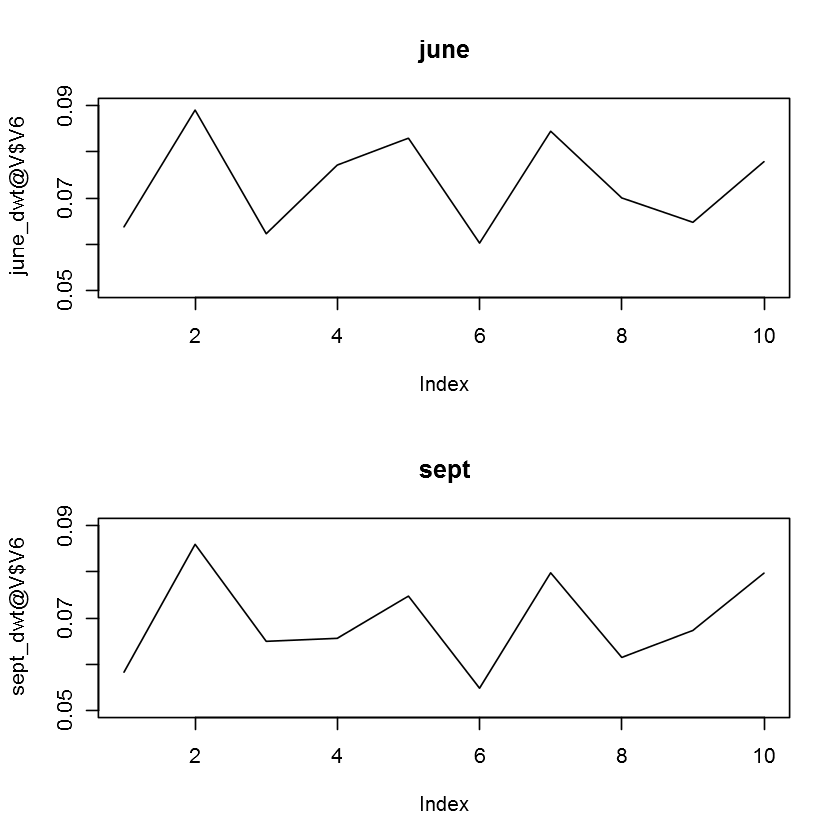

In [125]:
par(mfrow=2:1)
plot(june_dwt@V$V6, type='l',ylim = c(0.05, 0.09), main='june')
plot(sept_dwt@V$V6, type='l',ylim = c(0.05, 0.09), main='sept')